# Formulaic Language in the Pentateuch

In reading through the Pentateuch, I've noticed that several sections contain a lot of repetition. This formulaic language seems to serve as a way of organizing and carefully structuring segments of text. In this notebook, we will visualize this phenomenon in the Pentateuch with a heatmap. A heatmap is a graph which visualizes integers as "temperatures". The lower a value, the "cooler" it is, and vice versa. The colors blue and red are used to represent cold and hot values. 

Our method for quantifying repetitive language is to measure the similarity of a given verse to another verse in the Pentateuch which is most similar to it. The method of measuring similarity used herein is inspired by the [parallels data of Dirk Roorda and Martijn Naaijer](https://nbviewer.jupyter.org/github/etcbc/parallels/blob/master/programs/parallels.ipynb):

> We have to find passages in the MT that are similar. Therefore we chunk the text in some way, and then compute the similarities between pairs of chunks.
> There are many ways to define and compute similarity between texts. Here, we have tried two methods SET and LCS. Both methods define similarity as the fraction of common material with respect to the total material. *-Roorda & Naaijer*

The method we will use herein is the [longest common subsequence](https://en.wikipedia.org/wiki/Longest_common_subsequence_problem) (LCS):

> The LCS method is less reductive: chunks are strings of lexemes, so the order and number of occurrences of words is retained. *-Roorda & Naaijer*

The [Levenshtein algorithm](https://pypi.org/project/python-Levenshtein/) will be used to produce the LCS data.

While Roorda and Naaijer provide pre-processed parallels data in the [Parallels repository](https://github.com/ETCBC/parallels), only similarities above a threshold of 75% are exported. For our purposes, we need similarity data for every verse in the Pentateuch. **Thus, before we can visualize verse similarity, we must perform a pairwise comparison of all verses in the Pentateuch.**

## Load Packages and Data

In [1]:
# load data containers, algorithms, visualizers, and Text-Fabric
import collections
from datetime import datetime
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import Levenshtein as lev
import numpy as np
from tf.app import use

# load BHSA Hebrew data
A = use('bhsa')

# classes used to access data loaded in TF
api = A.api
F, E, T, L = api.F, api.E, api.T, api.L

	connecting to online GitHub repo annotation/app-bhsa ... connected
Using TF-app in /Users/cody/text-fabric-data/annotation/app-bhsa/code:
	rv1.2=#5fdf1778d51d938bfe80b37b415e36618e50190c (latest release)
	connecting to online GitHub repo etcbc/bhsa ... connected
Using data in /Users/cody/text-fabric-data/etcbc/bhsa/tf/c:
	rv1.6 (latest release)
	connecting to online GitHub repo etcbc/phono ... connected
Using data in /Users/cody/text-fabric-data/etcbc/phono/tf/c:
	r1.2 (latest release)
	connecting to online GitHub repo etcbc/parallels ... connected
Using data in /Users/cody/text-fabric-data/etcbc/parallels/tf/c:
	r1.2 (latest release)
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used


## Levenshtein Distance for the LCS Measurement

> Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. -[Wikipedia](https://en.wikipedia.org/wiki/Levenshtein_distance)

The Levenshtein distance method essentially counts the number of edits needed to make two strings of characters equivalent. A simple example is given below.

In [2]:
cat = 'cat'
bat = 'bat'

In order to make "bat" equivalent to "cat", we would need to edit one letter, "b". The Levenshtein distance is thus 1. We can find this distance dynamically with the Levenshtein package.

In [3]:
lev.distance(cat, bat)

1

The distance between two strings can also be represented as a ratio/percentage by dividing the difference of total characters and distance by total characters. In our example, this would be:
```
(3-1)÷3 = 0.66...
```
I.e. 3 total characters, minus the edit distance of 1, divided by 3 total characters. We can use the Levenshtein package for this calculation also:

In [4]:
lev.ratio(cat, bat)

0.6666666666666666

Thus, in this model we can say that "cat" and "bat" are 67% similar based on edit distance. 

## Implementation 

Before we can apply the similarity tests, we need to pre-process the verse data

First, for every verse in the Pentateuch, we store its string representation. **For the sake of maximizing the effectiveness of our model, we lexicalize the text and strip out accentuation and vocalization.**

In [5]:
pentateuch_books = {
    'Genesis','Exodus',
    'Leviticus', 'Numbers',
    'Deuteronomy'
}

verses = {}

for book in pentateuch_books:
    book_node = T.nodeFromSection((book,))
    for verse in L.d(book_node,'verse'):
        verses[verse] = T.text(verse, fmt='lex-orig-plain', descend=True)

We now have a dataset that maps verse nodes to their plain-text representation. A sample of the dataset is shown below.

In [6]:
list(verses.items())[:5]

[(1417959,
  'ו דבר יהוה אל משׁה ב מדבר סיני ב אהל מועד ב אחד ל ה חדשׁ ה שׁני ב ה שׁנה ה שׁני ל יצא מן ארץ מצרים ל אמר '),
 (1417960,
  'נשׂא את ראשׁ כל עדה בן ישׂראל ל משׁפחה ל בית אב ב מספר שׁם כל זכר ל גלגלת '),
 (1417961,
  'מן בן עשׂרים שׁנה ו מעל כל יצא צבא ב ישׂראל פקד את ל צבא אתה ו אהרן '),
 (1417962, 'ו את היה אישׁ אישׁ ל ה מטה אישׁ ראשׁ ל בית אב הוא '),
 (1417963, 'ו אלה שׁם ה אישׁ אשׁר עמד את ל ראובן אליצור בן שׁדיאור ')]

## Pairwise Operation

We want to calculate the Levenshtein ratio for every two verses in the Pentateuch. In order to do so, we must iterate over every verse in the Pentateuch multiplied by every other verse in the Pentateuch. This operation is **pairwise**, i.e., comparing every possible pair of verses with the Levenshtein ratio. The results will be stored in a dictionary, a kind of data container. 

This process is computationally intensive. It is a quadratic formula. With 5,853 verses, there are a total of 5,852 x 5852 comparisons to be made—that is:

In [8]:
print(f'{5852*5852} comparisons to do')

34245904 comparisons to do


Now we make the comparisons and print updates as we go.

In [9]:
similarities = collections.defaultdict(list)

start_time = datetime.now()

print(f'{datetime.now()-start_time}\tcomparing {len(verses)} verses...')

for verse, text in verses.items():
    for verse2, text2 in verses.items():
        
        # skip comparisons with self
        if verse == verse2:
            continue
            
        ratio = round(lev.ratio(text, text2), 2)
        similarities[verse].append((ratio, verse2))
        
    # report progress
    if (len(similarities) % 500 == 0) and len(similarities):
        print(f'\t| {datetime.now()-start_time}  done with verse number {len(similarities)}...')
            
print(f'{datetime.now()-start_time}\tdone!')

0:00:00.000057	comparing 5853 verses...
	| 0:00:25.878110  done with verse number 500...
	| 0:00:53.206325  done with verse number 1000...
	| 0:01:19.862049  done with verse number 1500...
	| 0:01:47.665621  done with verse number 2000...
	| 0:02:16.689516  done with verse number 2500...
	| 0:02:46.663702  done with verse number 3000...
	| 0:03:12.739056  done with verse number 3500...
	| 0:03:39.574869  done with verse number 4000...
	| 0:04:06.141646  done with verse number 4500...
	| 0:04:34.744923  done with verse number 5000...
	| 0:05:01.774956  done with verse number 5500...
0:05:21.444679	done!


## Explore Data

Let's have a look at the data. We need an example passage.

In [10]:
gen_5_5 = T.nodeFromSection(('Genesis', 5, 5))

A.plain(gen_5_5)

We have selected the verse node for Genesis 5:5 from the Text-Fabric text-graph. The data model used by Text-Fabric is described [here](https://annotation.github.io/text-fabric/Model/Data-Model/). In short, TF models a text as a [relational graph](https://en.wikipedia.org/wiki/Graph_theory) which contains nodes (i.e. words, phrases, clauses, sentences, verses, chapters, etc.) and edges (relations between the nodes). 

The node we have selected for Genesis 5:5 is a simple ID number which can be used to look up features on the node that are stored in the dictionary.

In [11]:
# the node ID number for Gen 5:5
gen_5_5

1414464

We select the similarity data from the dictionary below. 

In [12]:
similarities[gen_5_5][:10]

[(0.45, 1417959),
 (0.41, 1417960),
 (0.39, 1417961),
 (0.51, 1417962),
 (0.46, 1417963),
 (0.34, 1417964),
 (0.33, 1417965),
 (0.31, 1417966),
 (0.28, 1417967),
 (0.45, 1417968)]

Note that the results are not yet sorted. We can do that by iterating through the dataset and applying a sort method.

In [13]:
for verse, sims in similarities.items():
    similarities[verse] = sorted(sims, reverse=True)

Now let's have a look again at the sorted data for Genesis 5:5.

In [14]:
gen_5_5_sims = similarities[gen_5_5][:10]

gen_5_5_sims

[(0.84, 1414588),
 (0.76, 1414476),
 (0.76, 1414470),
 (0.75, 1414490),
 (0.74, 1414486),
 (0.74, 1414479),
 (0.73, 1414467),
 (0.72, 1414473),
 (0.7, 1414482),
 (0.7, 1414463)]

We are looking at the top 10 similarities and their respective verse nodes. We can see what these verses look like below.

In [15]:
A.plain(gen_5_5)
display(HTML('<hr>'))
print()

for sim, verse in gen_5_5_sims:
    A.plain(verse)
    print(f'similarity: {sim}%')
    print()

similarity: 0.84%



similarity: 0.76%



similarity: 0.76%



similarity: 0.75%



similarity: 0.74%



similarity: 0.74%



similarity: 0.73%



similarity: 0.72%



similarity: 0.7%



similarity: 0.7%



These are good results, showing formulaic language, especially with the phrase ויהי כל־ימי־, and שׁנה וימת... Note that with the exception of Genesis 9, the formulaic language is clustered together in Genesis 5. 

# Analysis

For every verse, select the highest similarity found. For our purposes here, it does not matter how far apart high-similarity verses occur. This score is then plotted on a 1-dimensional heatmap. Verses which are more similar to *any other* verse in the Pentateuch will be more red ("warm"), whereas those lacking similarity will be more blue ("cold"). The X-axis of the plot will be a verse's sequential position in the Pentateuch (e.g. `1` on the X-axis is the first verse in the Pentateuch). 

The heatmap code is modified from [here](https://stackoverflow.com/questions/45841786/creating-a-1d-heat-map-from-a-line-graph).

In [104]:
verse2sim = sorted((verse, simis[0][0]) for verse, simis in similarities.items())
sims = np.array([sim for verse,sim in verse2sim])
bins = np.arange(len(similarities))
extent=[bins.min(), bins.max(), 0, 1]

In [113]:
# build x-ticks per chapter
chapter2start = {}

i = 0 
for verse,sim in verse2sim:
    book,chapter,verse = T.sectionFromNode(verse)
    ref = f'{book[:3]} {chapter}'
    if ref not in chapter2start:
        chapter2start[ref] = i
    i += 1

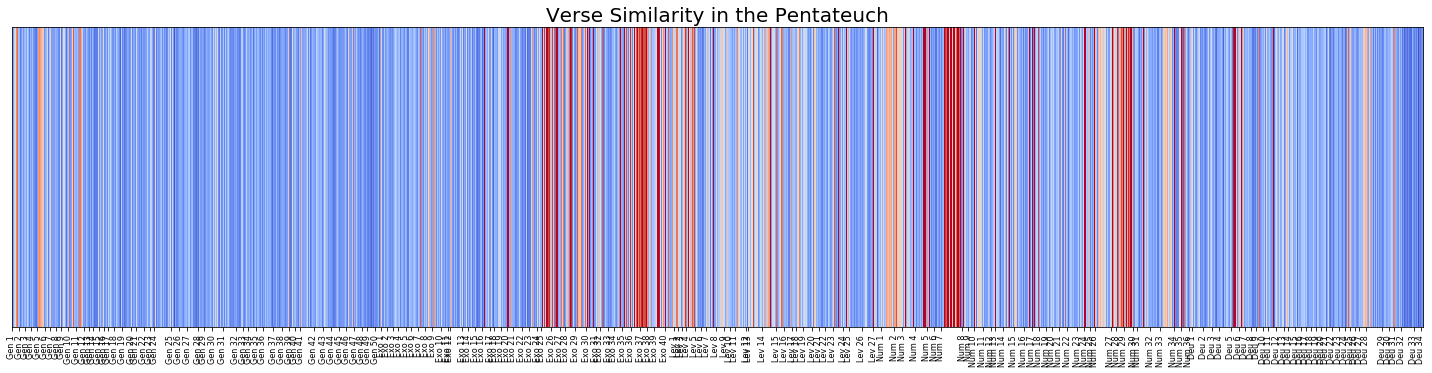

In [137]:
plt.figure(figsize=(20, 5))
plt.imshow(sims[np.newaxis,:], cmap="coolwarm", aspect="auto", extent=extent)
plt.yticks([])
plt.xlim(extent[0], extent[1])
plt.xticks(list(chapter2start.values()), list(chapter2start.keys()), rotation=90, size=8)
plt.tight_layout()
plt.title('Verse Similarity in the Pentateuch', size=20)
#plt.savefig('/Users/cody/Desktop/pentateuch_sims.png', dpi=300, bbox_inches='tight')
plt.show()